In [1]:
import tensorflow as tf
import numpy as np
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
print(tf.__version__)


2.4.0


In [3]:
!cat '/content/drive/My Drive/MasterThesis/Datasets/Offensive2020/trainDev/NOT_OFF/1000.txt'

@USER @USER ان شاء الله يا غالي حبيبي يا محمد<LF>ودايما متجمعين علي عشق الكيان	NOT_OFF	NOT_HS


In [4]:
# #Read stop words file and convert into list
# with open('/content/drive/MyDrive/MasterThesis/ar_stop_words.txt') as f:
#     stop_words = f.readlines()  
# # you may also want to remove whitespace characters like `\n` at the end of each line
# stop_words = [x.strip() for x in stop_words] 
# stop_words[:10]

In [5]:
from nltk.corpus import stopwords
stopwords_list = stopwords.words('arabic')
# stopwords_list=np.array(stopwords_list)
# stopwords_list

In [6]:
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/content/drive/My Drive/MasterThesis/Datasets/Offensive2020/trainDev",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
   
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/content/drive/My Drive/MasterThesis/Datasets/Offensive2020/trainDev",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/content/drive/My Drive/MasterThesis/Datasets/Offensive2020/test", batch_size=batch_size
)

print(
    "Number of batches in raw_train_ds: %d"
    % tf.data.experimental.cardinality(raw_train_ds)
)
print(
    "Number of batches in raw_val_ds: %d" % tf.data.experimental.cardinality(raw_val_ds)
)
print(
    "Number of batches in raw_test_ds: %d"
    % tf.data.experimental.cardinality(raw_test_ds)
)

Found 8000 files belonging to 2 classes.
Using 6400 files for training.
Found 8000 files belonging to 2 classes.
Using 1600 files for validation.
Found 2000 files belonging to 2 classes.
Number of batches in raw_train_ds: 200
Number of batches in raw_val_ds: 50
Number of batches in raw_test_ds: 63


In [7]:
# It's important to take a look at your raw data to ensure your normalization
# and tokenization will work as expected. We can do that by taking a few
# examples from the training set and looking at them.
# This is one of the places where eager execution shines:
# we can just evaluate these tensors using .numpy()
# instead of needing to evaluate them in a Session/Graph context.
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i].decode('utf-8').strip())
        print(label_batch.numpy()[i])
        print('--------------------------------')

RT @USER: يا رب يا عزيز يا جبار .. انك القادر على كل شيء .. يا رب فرحه اتحاديه تُنسينا كل الهموم والمشاكل الي صارت هالموسم يا رب العباد…	NOT_OFF	NOT_HS
0
--------------------------------
@USER @USER يا جامع يا رقيب يا رب تلقاها	NOT_OFF	NOT_HS
0
--------------------------------
راهنت عليك ولم اخسر ❤️❤️<LF>يا وحش يا جلاد يا كبير<LF>يا مرعب يا قناص يا يصياد<LF>🖤💛🖤💛🖤💛🖤💛<LF>#الاتحاد_النصر URL	NOT_OFF	NOT_HS
0
--------------------------------
RT @USER: كانت أيام يا وطني<LF>زي الأحلام يا وطني 🎶	NOT_OFF	NOT_HS
0
--------------------------------
تمثيل يا رزان تمثيل يا رزان تمثيل يا رزان تمثيل يا رزان تمثيل يا رزان تمثيل يا رزان	NOT_OFF	NOT_HS
0
--------------------------------


In [8]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to NOT_OFF
Label 1 corresponds to OFF


In [9]:
import string
import re
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML). Because of this, we will need to
# create a custom standardization function.

def custom_standardization(input_data, remove_stop_words=True, lemmatize_words=True):
    # if remove_stop_words:
    #   # input_data = input_data.split()
    #   input_data = [w for w in input_data if not w in stop_words]
    #   input_data = " ".join(input_data)

    # stripped_html=re.sub(r'(.)\1+', r'\1\1', str(input_data))
    # stripped_html=
    stripped_html = tf.strings.regex_replace(input_data, "[a-zA-Z]|\d+|[٠١٢٣٤٥٦٧٨٩]", " ")
    stripped_html = tf.strings.regex_replace(stripped_html, "[.،,!?؟\\-”“٪ًَ]", " ")
    
    stripped_html = tf.strings.regex_replace(stripped_html, "[إأآا]", "ا")
    stripped_html = tf.strings.regex_replace(stripped_html, "ة", "ه")
    stripped_html=tf.strings.regex_replace(stripped_html, "[(\U0001F600-\U0001F92F|\U0001F300-\U0001F5FF|\U0001F680-\U0001F6FF|\U0001F190-\U0001F1FF|\U00002702-\U000027B0|\U0001F926-\U0001FA9F|\u200d|\u2640-\u2642|\u2600-\u2B55|\u23cf|\u23e9|\u231a|\ufe0f)|\u2069|\u2066]+", " ")
    # stripped_html = ' '.join([word for word in input_data if word not in stopwords_list])

    # pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('arabic')) + r')\b\s*')
    # stripped_html = pattern.sub('', str(stripped_html))

  
    # return (stripped_html)

    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
     
    )


# Model constants.
max_features = 15000
embedding_dim = 128
sequence_length = 500

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.

# tock=tf.keras.preprocessing.text.Tokenizer(
#     num_words=None,
#     filters=stopwords_list)
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length, 
    # split=tokenizer.tokenize,
    
)

# pipeline = keras.layers.PreprocessingStage([vectorize_layer, discretization])
# pipeline.adapt(data_sample)

# Now that the vocab layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)

In [10]:
# Let's make a text-only dataset (no labels):
# text_StopWord = stopwords_list.map(lambda x, y: x)
# Let's call `adapt`:
# stopwords_list=vectorize_layer.adapt(stopwords_list)
# stopwords_list

In [11]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    # removeStopWords(text,stopword)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
# sw=stopwords_list.apply(vectorize_text)
# # Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)
# train_ds.apply(removeStopWords(stopwords))

In [12]:
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))


Vocabulary size: 15000


In [13]:
# vectorize_layer.get_vocabulary()
# stopwords_list=map(vectorize_text,stopwords_list)
# stopwords_list=list(map(vectorize_layer,stopwords_list))

# type(stopwords_list)

# for ch in map(vectorize_layer,stopwords_list):
    # print(ch)
    

In [14]:
# import nltk 
# train_ds=[word for word in nltk.tokenize.wordpunct_tokenize(str(train_ds)) and word not in stopwords_list]

In [15]:
vocab = np.array(vectorize_layer.get_vocabulary())
vocab[:10]

array(['', '[UNK]', 'يا', 'و', 'من', 'الله', 'في', 'ما', 'رب', 'لا'],
      dtype='<U107')

In [16]:
# vocabneww=np.array(stopwords_list)
# vocabneww[:1]

In [17]:
# new_arr = np.delete(vocab,vocabneww)
# print(new_arr)

In [18]:
# Remove stop words from Vocab list 
# vocabnew = [word for word in vocab if word not in stopwords_list]
# vocabnew=np.array(vocabnew)
# vocabnew[:100]


In [19]:
encoded_example = vectorize_layer(text_batch)[:10].numpy()
encoded_example

array([[    2,     8,     2, ...,     0,     0,     0],
       [    2,  1641,     2, ...,     0,     0,     0],
       [    1,    19,   651, ...,     0,     0,     0],
       ...,
       [    2,     1,     2, ...,     0,     0,     0],
       [ 8443,    11, 13940, ...,     0,     0,     0],
       [    2,  2747,     2, ...,     0,     0,     0]])

In [20]:
for n in range(10):
  print("Original: ", text_batch[n].numpy().decode('utf-8').strip())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  RT @USER: يا رب يا عزيز يا جبار .. انك القادر على كل شيء .. يا رب فرحه اتحاديه تُنسينا كل الهموم والمشاكل الي صارت هالموسم يا رب العباد…	NOT_OFF	NOT_HS
Round-trip:  يا رب يا عزيز يا جبار انك القادر على كل شيء يا رب فرحه اتحاديه [UNK] كل الهموم والمشاكل الي صارت هالموسم يا رب [UNK]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

Original:  @USER @USER يا جامع يا رقيب يا رب تلقاها	NOT_OFF	NOT_HS
Round-trip:  يا جامع يا رقيب يا رب تلقاها                                                                                                                           

In [21]:
# text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
# x = vectorize_layer(text_input)
# x = layers.Embedding(max_features + 1, embedding_dim)(x)

from tensorflow.keras import layers

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [ ]:
epochs = 3

# Fit the model using the train and test datasets.
# model.fit(train_ds, validation_data=val_ds, epochs=epochs
          # ,callbacks=my_callbacks,verbose=0)

#Fit on the training data.
from keras.callbacks import EarlyStopping

history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,
          callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/3
200/200 [==============================] - 693s 3s/step - loss: 0.5408 - accuracy: 0.7807 - val_loss: 0.4454 - val_accuracy: 0.7975
Epoch 2/3
200/200 [==============================] - 34s 169ms/step - loss: 0.3716 - accuracy: 0.8322 - val_loss: 0.2918 - val_accuracy: 0.8850
Epoch 3/3
200/200 [==============================] - 34s 171ms/step - loss: 0.1254 - accuracy: 0.9520 - val_loss: 0.3687 - val_accuracy: 0.8900


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

63/63 [==============================] - 860s 12s/step - loss: 6.0204 - accuracy: 0.1160
Test Loss: 6.020442485809326
Test Accuracy: 0.11599999666213989


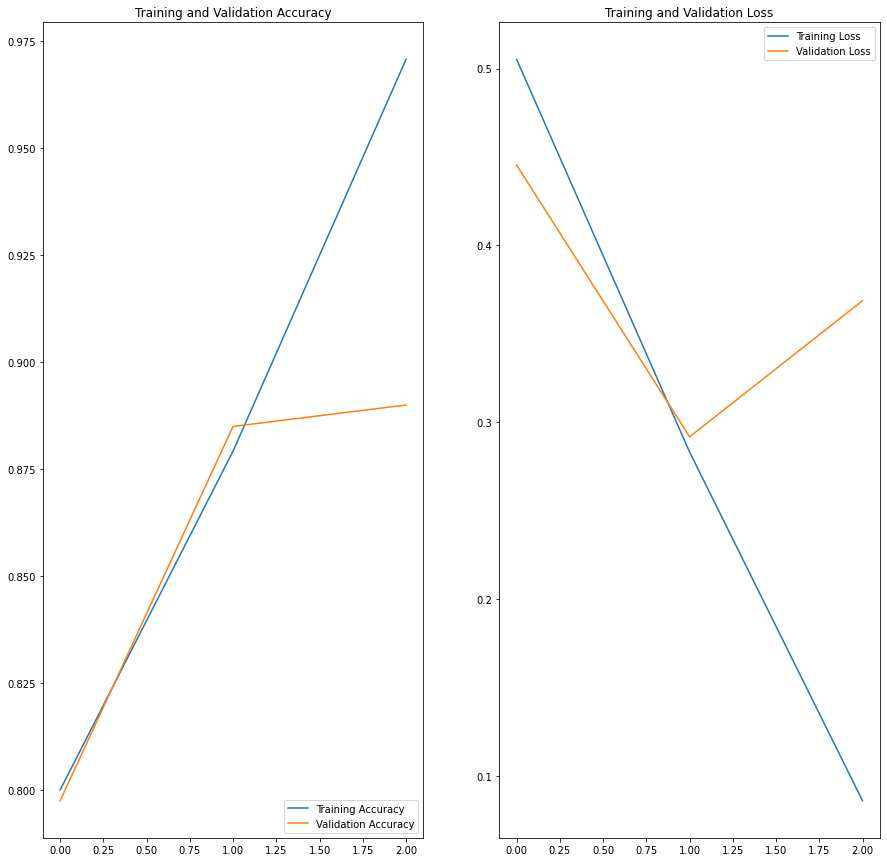

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

#epochs_range = range(22)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# A string input
inputs = tf.keras.Input(shape=(1,), dtype="string")
# Turn strings into vocab indices
indices = vectorize_layer(inputs)
# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
end_to_end_model.evaluate(raw_test_ds)

63/63 [==============================] - 5s 67ms/step - loss: 5.9594 - accuracy: 0.1202


[6.02044153213501, 0.11599999666213989]